# 1.1 Erdős–Rényi Random Graph (ER Model)

In this couples of chapters, I am gonna learn while implementing some basic random graph models to build intuition about graph structural properties.

In this chapter,exploring the ER random graph model. 

1. Research the ER model and its properties.
2. Generate an ER graph with NetworkX.
3. Compute basic structural properties (nodes, edges, degree, components).
4. Visualize the degree distribution and compare it to a Poisson-like shape.
5. Prepare intuition for comparing ER vs **reeeeeeal** Ethereum transaction networks.


## 1. Import libraries & basic setup

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


## 2. What is an Erdős–Rényi (ER) random graph?

The ER model is one of the simplest random graph models.

There are two common versions:

- **G(n, p)**: fix `n` nodes, and for every possible pair of nodes `(i, j)`,
  independently place an edge with probability `p`.
- **G(n, m)**: fix `n` nodes and exactly `m` edges, and choose those `m` edges uniformly at random.

In this notebook I use **G(n, p)**, which is what `networkx.erdos_renyi_graph` implements.

**Typical properties of G(n, p):**

- The degree distribution is approximately **binomial**, and for large `n` and small `p`,
  it can be approximated by a **Poisson distribution**.
- There is **no preferential attachment** or structure: edges are independent.
- Clustering coefficient is usually **low**.
- There is a **giant connected component** if `p` is large enough.

We will see later that **real-world networks (e.g. Ethereum)** usually do **not** look like ER graphs:
they have **heavy-tailed degree distributions** and **hubs**, which ER graphs don't.


## 3. Choose parameters (n, p)

Base my laptop capabilities and for demonstration purposes, I will choose:

In [11]:
# Number of nodes
n = 5000

# Edge probability
p = 0.001  # around avg degree ~ n * p = 5

print(f"Planned ER graph parameters: n={n}, p={p}, expected edges ≈ {n*(n-1)/2*p:.0f}")
print(f"Expected average degree ≈ {p * (n-1):.2f}")


Planned ER graph parameters: n=5000, p=0.001, expected edges ≈ 12498
Expected average degree ≈ 5.00


## 4. Generate the ER graph

The number of edges will be close to the theoretical expectation:

$$
\mathbb{E}[|E|] \approx \frac{n (n-1)}{2} p
$$

But due to randomness it will not be exactly the same.


In [12]:
G_er = nx.erdos_renyi_graph(n=n, p=p, seed=42, directed=False)

print("=== ER Graph Generated ===")
print("Number of nodes:", G_er.number_of_nodes())
print("Number of edges:", G_er.number_of_edges())

# 5000 * 4999 / 2 * 0.001   compare 


=== ER Graph Generated ===
Number of nodes: 5000
Number of edges: 12158


## 5. Basic structural properties

In [13]:
# Compute basic metrics
num_nodes = G_er.number_of_nodes()
num_edges = G_er.number_of_edges()
avg_degree = 2 * num_edges / num_nodes

# Connected components
components = list(nx.connected_components(G_er))
num_components = len(components)
largest_cc_size = len(components[0])

print("=== Basic ER Graph Statistics ===")
print(f"Nodes: {num_nodes}")
print(f"Edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Number of connected components: {num_components}")
print(f"Largest connected component size: {largest_cc_size}")
print(f"Fraction of nodes in largest CC: {largest_cc_size / num_nodes:.2%}")


=== Basic ER Graph Statistics ===
Nodes: 5000
Edges: 12158
Average degree: 4.86
Number of connected components: 38
Largest connected component size: 4961
Fraction of nodes in largest CC: 99.22%


### Interpretation

- **Average degree**: should be close to `p * (n-1)`.
- **Number of connected components**:
  - For small `p`, the graph may be fragmented (many small components).
  - For larger `p`, a **giant connected component** appears.
- **Largest connected component (LCC)**:
  - Often contains a large fraction of the nodes when `p` is above the percolation threshold.

Later, when I analyze the Ethereum transaction graph, I will also check:

- number of nodes / edges,
- size of the largest connected (or weakly connected) component,

and compare with this ER baseline.


## 6. Degree distribution

Now, I will plot the degree distirbution of the ER graph and compare it to a Poisson distribution.

比较集中
It should be concentrated around the average degree, with a rapid decay for higher degrees.  Not like **ETH** graph which has a heavy tail. 

In [14]:
# Get degree sequence
degrees = np.array([deg for _, deg in G_er.degree()])

print("Min degree:", degrees.min())
print("Max degree:", degrees.max())
print("Average degree:", degrees.mean())


Min degree: 0
Max degree: 15
Average degree: 4.8632


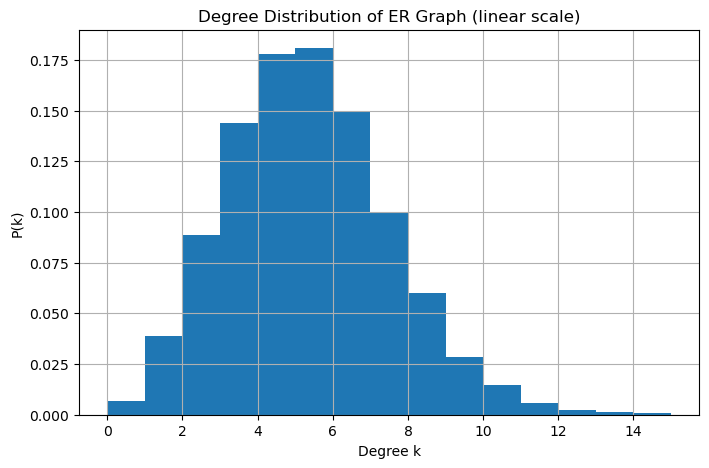

In [15]:
plt.figure()
plt.hist(degrees, bins=range(0, degrees.max()+1), density=True)
plt.title("Degree Distribution of ER Graph (linear scale)")
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.show()


loglog graph below, the degree distribution of ER graph drops off quickly

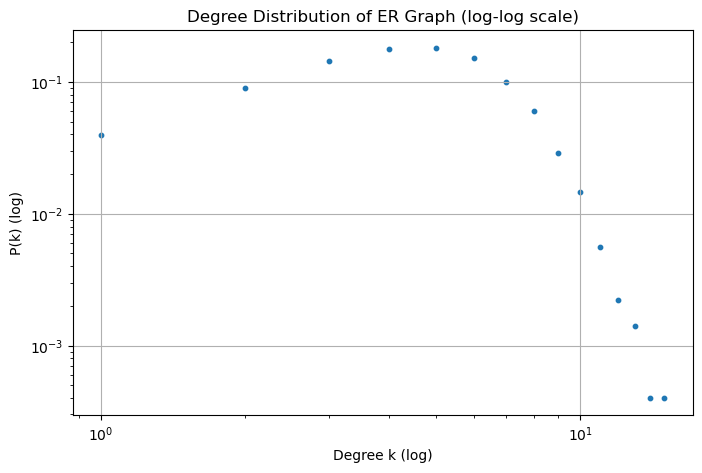

In [16]:
# Avoid zero-degree nodes for log-log plot
deg_nonzero = degrees[degrees > 0]

counts = np.bincount(deg_nonzero)
k_values = np.arange(len(counts))
prob = counts / counts.sum()

plt.figure()
plt.scatter(k_values[1:], prob[1:], s=10)
plt.xscale("log")
plt.yscale("log")
plt.title("Degree Distribution of ER Graph (log-log scale)")
plt.xlabel("Degree k (log)")
plt.ylabel("P(k) (log)")
plt.show()


### Interpretation of degree distribution

For an ER random graph:

- The degree distribution is approximately **Binomial(n-1, p)**.
- When `n` is large and `p` is small, this is close to a **Poisson distribution**.
- On a **log-log plot**, ER graphs **do not** show a straight line.
  This means they **do not follow a power-law distribution**.

In contrast, many real-world networks (social networks, web graphs, and blockchain transaction graphs)
tend to have:

- a **heavy-tailed** degree distribution,
- a few nodes with extremely large degree (`hubs`),
- which often follows a **power-law**.

Then we will later see that Ethereum is much closer to a **scale-free network** than to this ER model.


## 7. Clustering coefficient & path length (optional but recommended)


In [17]:
# Average clustering coefficient
clustering = nx.average_clustering(G_er)
print("Average clustering coefficient:", clustering)

# For path length, we usually use the largest connected component
largest_cc_nodes = max(nx.connected_components(G_er), key=len)
G_lcc = G_er.subgraph(largest_cc_nodes).copy()

avg_path_length = nx.average_shortest_path_length(G_lcc)
print("Average shortest path length (on LCC):", avg_path_length)


Average clustering coefficient: 0.000975382395382395
Average shortest path length (on LCC): 5.564527914507351


### Interpretation

- **Clustering coefficient** in ER graphs is typically **low** and roughly equal to `p`.
- **Average path length** is relatively small and scales like `O(log n)`.

Later, when we inspect the Ethereum network, we can compare:

- Are paths also short?
- Is clustering higher or lower than ER?
- Does Ethereum look "more structured" than a random ER graph?


## 8. Conclusion

1. generated an **Erdős–Rényi G(n, p) graph** with `networkx.erdos_renyi_graph`.
2. computed basic properties:
   - number of nodes / edges,
   - average degree,
   - connected components,
   - largest connected component size.
3. research the **degree distribution**:
   - It is narrow (not heavy-tailed),
   - Approximates a **Binomial / Poisson** distribution,
   - Does **not** look like a power-law on a log-log plot.
4. computed:
   - clustering coefficient (low),
   - average shortest path length (on the largest CC).

**Key idea:**

> ER graphs are "random" with independent edges and low clustering.  
> Real-world networks (like Ethereum) are **not** ER:
> they have hubs, heavy-tailed degree distributions, and more structure.

In the next notebooks:

- I will explore:
  - **Watts–Strogatz (WS)** small-world graphs,
  - **Barabási–Albert (BA)** scale-free graphs,
- And later compare them with the **real Ethereum transaction network**.
